In [1]:
import os
os.environ["PATH"] += ":/usr/local/texlive/2024/bin/universal-darwin"

import numpy as np
import matplotlib.pylab as plt

from helpers import save_dict,load_dict

from sklearn.linear_model import LinearRegression


In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 15,
    "font.family": "Helvetica"

})

column_width = 3.75
square_fig_size=(2*column_width,3/2*column_width)


# Helper Functions

In [3]:
def get_intercept_error(X, Y, slope):
    mean_x = np.mean(X)
    mean_y = np.mean(Y)
    intercept_ols = mean_y - slope * mean_x
    intercept_error_ols = np.std(Y - (slope * X + intercept_ols))
    return intercept_error_ols


# Load Data

In [4]:
Ls_1 = np.arange(6,21,2)
Ls_2 = np.arange(24,33,4)
Ls = np.concatenate((Ls_1,Ls_2),axis=0)

rates = [0.475, 0.25]
scales = [0.25,0.5,1.,2.,4.]

data = load_dict('./final_data/final_energy_data.pkl')

# Fitting

In [5]:
colorscale = plt.get_cmap('plasma')
shades = np.linspace(0.,0.9,len(scales)+1)[::-1][:-1]
colors = colorscale(shades)
markers = {0.475:'s',0.25:'8'}
markersizes = {0.475:6,0.25:8}
alphas = {0.475:0.5,0.25:1.0}
linestyles= {0.475:'--',0.25:'-'}
bigger_font_size = 22

In [6]:
zero_var_energy = {}

for bc in ['open', 'periodic']:

    if bc=='open':
        which_scales=[2.0,4.0]
    else:
        which_scales=[1.0,2.0,4.0]
        # which_scales=scales

    print('-'*50)
    print(f'{bc}')
    print('-'*50)

    zero_var_energy[bc] = {}
    title = bc
    data_ = data[bc]

    for L in Ls:    
        zero_var_energy[bc][L] = {}

        ## Gather all the data points for a given L
        toplot_x = []
        toplot_y = []
        toplot_yerr = []
        for rate_i, rate in enumerate(rates):
            for scale_i, scale in enumerate(which_scales):
                N = L**2
                if (f'L={L}' in data_[f'rate={rate}'][f'scale={scale}'].keys()):
                    if 'final energy' in data_[f'rate={rate}'][f'scale={scale}'][f'L={L}'].keys():
                        en = np.real(data_[f'rate={rate}'][f'scale={scale}'][f'L={L}']['final energy'])
                        var = np.real(data_[f'rate={rate}'][f'scale={scale}'][f'L={L}']['final energy var'])
                        err = np.real(data_[f'rate={rate}'][f'scale={scale}'][f'L={L}']['final energy sterr'])
                        toplot_x.append(var)
                        toplot_y.append(en)   
                        toplot_yerr.append(err)   
        zero_var_energy[bc][L]['energies'] = np.array(toplot_y)
        zero_var_energy[bc][L]['variances'] = np.array(toplot_x)
        zero_var_energy[bc][L]['errors'] = np.array(toplot_yerr)

        ## Perform a linear fit through x=var(E) y=E 
        if len(toplot_x) > 1:
            reg_x = np.array(toplot_x)[:,np.newaxis]
            reg_y = toplot_y
            reg = LinearRegression().fit(reg_x, reg_y)     
            score = reg.score(reg_x, reg_y)
            err = get_intercept_error(reg_x, reg_y, reg.coef_) # assumes homoskedasticity

            zero_var_energy[bc][L]['slope'] = reg.coef_
            zero_var_energy[bc][L]['y-int'] = reg.intercept_
            zero_var_energy[bc][L]['y-int err'] = err
            zero_var_energy[bc][L]['R^2'] = score
            zero_var_energy[bc][L]['residuals'] = reg_y - (reg.coef_*toplot_x+reg.intercept_)
            zero_var_energy[bc][L]['predicted ys'] = reg.coef_*toplot_x+reg.intercept_

            min_energy = min(zero_var_energy[bc][L]['energies'])
            min_energy_i = np.where(zero_var_energy[bc][L]['energies']==min_energy)
            print(f"Min energy L={L}: {min_energy} +/- {zero_var_energy[bc][L]['errors'][min_energy_i]}")


--------------------------------------------------
open
--------------------------------------------------
Min energy L=6: -0.6035169495476617 +/- [6.14800874e-06 6.14800874e-06]
Min energy L=8: -0.619034469127655 +/- [5.79811706e-06]
Min energy L=10: -0.628656005859375 +/- [8.53216445e-06]
Min energy L=12: -0.6352005534701877 +/- [6.85537914e-06]
Min energy L=14: -0.6399285841961295 +/- [5.65640894e-06]
Min energy L=16: -0.6435218453407288 +/- [7.19656242e-06]
Min energy L=18: -0.6463365437072 +/- [5.09118016e-06]
Min energy L=20: -0.6485899353027343 +/- [4.99776753e-06]
Min energy L=24: -0.6519823604159884 +/- [6.75559124e-06]
--------------------------------------------------
periodic
--------------------------------------------------
Min energy L=6: -0.6788689295450846 +/- [1.71650859e-05 1.71650859e-05]
Min energy L=8: -0.6734647750854492 +/- [2.31294945e-05]
Min energy L=10: -0.6715101623535157 +/- [2.19668495e-05]
Min energy L=12: -0.6706186400519477 +/- [2.26829028e-05]
Min ene

#### Plotting

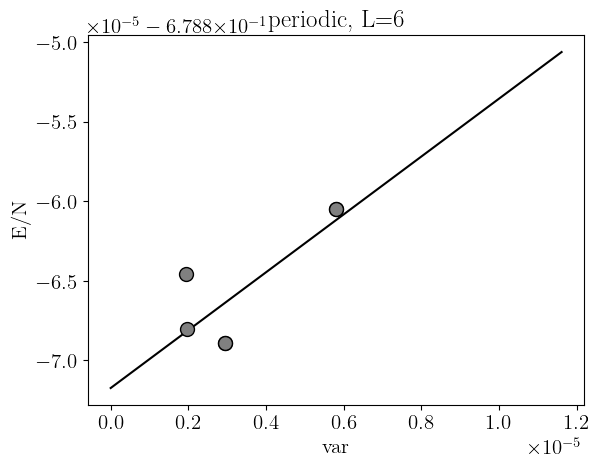

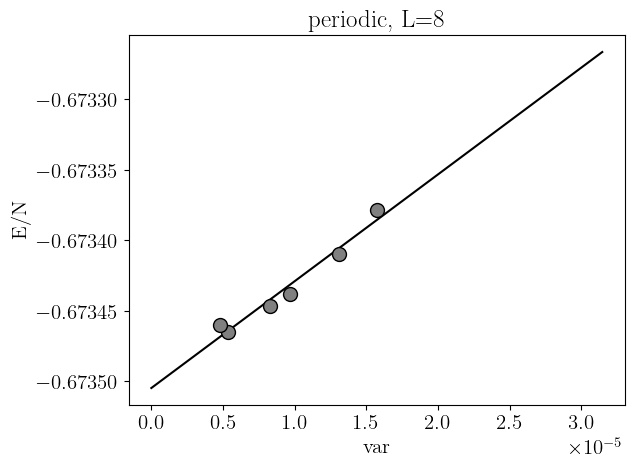

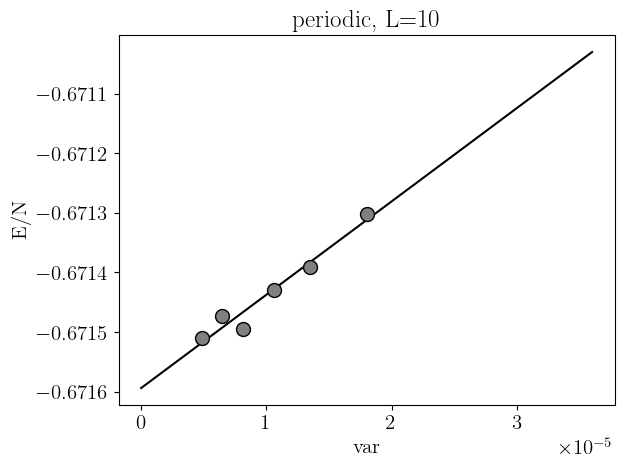

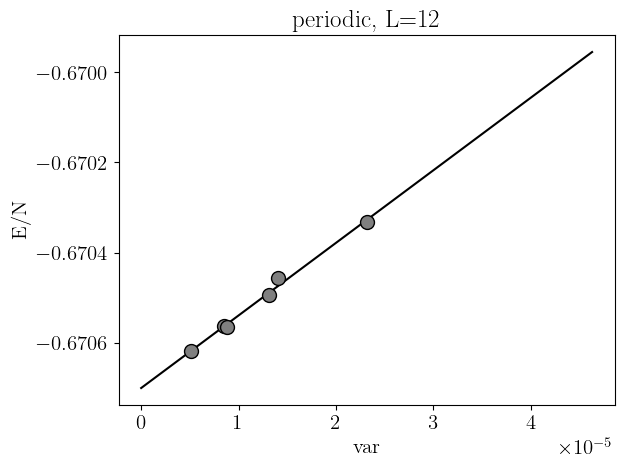

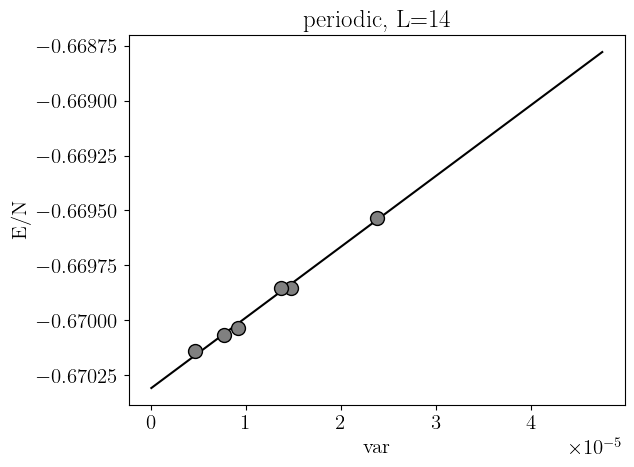

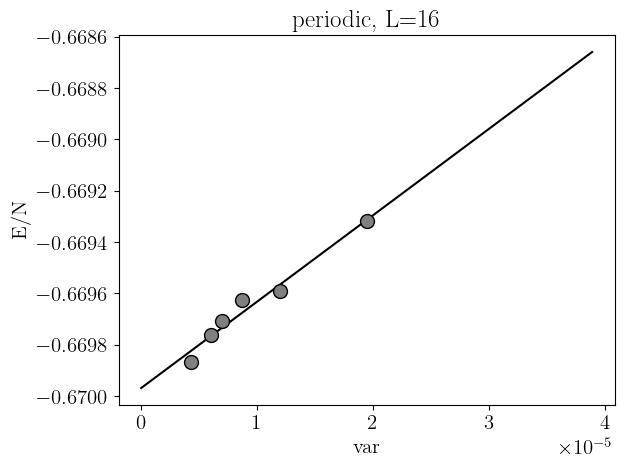

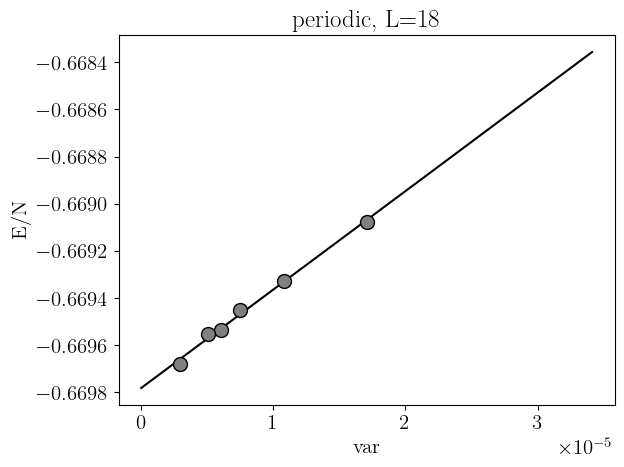

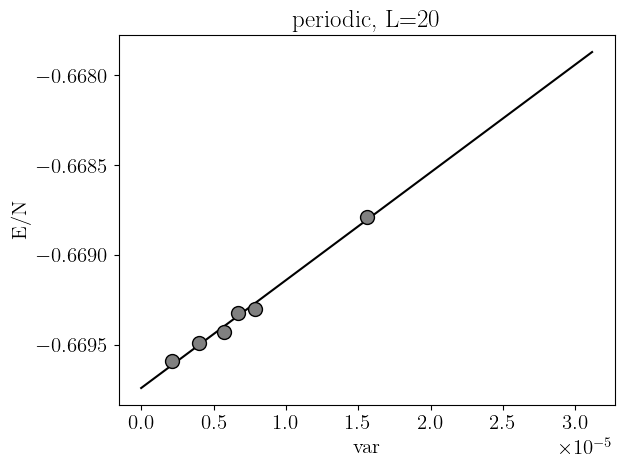

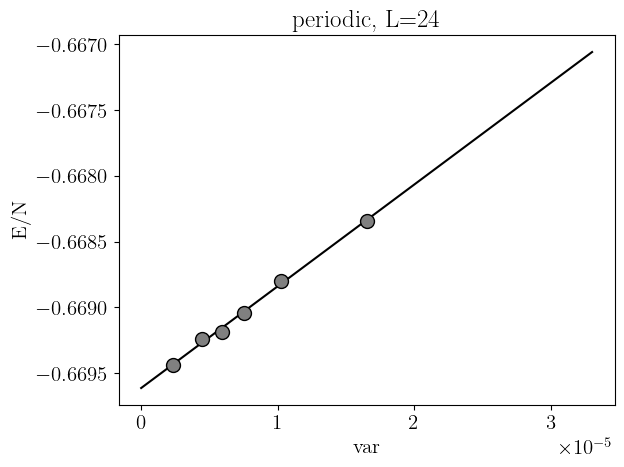

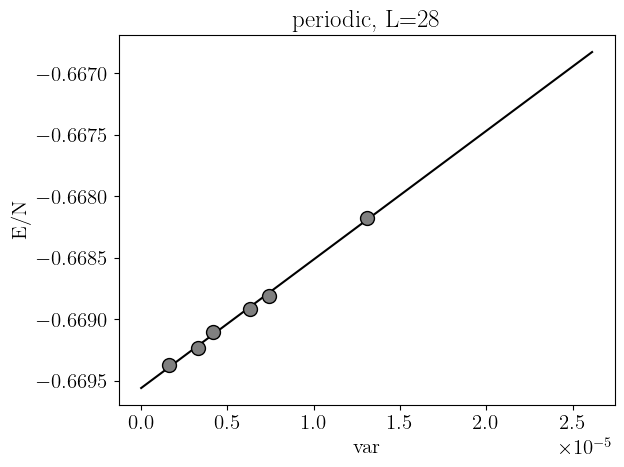

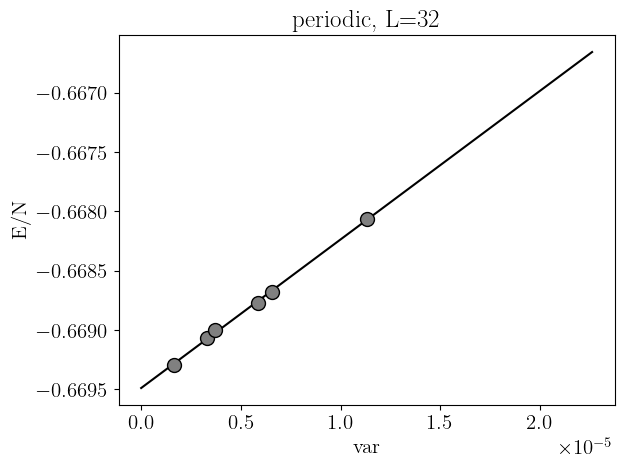

In [7]:
bc = 'periodic'

for L in Ls:
    if 'slope' in zero_var_energy[bc][L].keys():
        x = zero_var_energy[bc][L]['variances']
        y = zero_var_energy[bc][L]['energies']
        slope = zero_var_energy[bc][L]['slope']
        y_int = zero_var_energy[bc][L]['y-int']
        y_int_err = zero_var_energy[bc][L]['y-int err']

        x_mesh = np.arange(0, 2*max(x), 10**-10)
        plt.errorbar(x, y,yerr=np.sqrt(x)/10000,
                    marker='o',fmt='o',ms=10,capsize=0,
                    mfc='grey',mec='k',c='k')                

        plt.plot(x_mesh,slope*x_mesh+y_int,color='k')

        plt.ylabel('E/N')
        plt.xlabel('var')
        plt.title(bc+f", L={L}")
        plt.show()

# Resampling

In [8]:
Nb = 1000

In [9]:
np.random.seed(100)

for bc in ['open', 'periodic']:
    print('-'*50)
    print(f'{bc}')
    print('-'*50)
    for L in Ls:

        if 'residuals' in zero_var_energy[bc][L].keys():
            xs = np.reshape(np.tile(zero_var_energy[bc][L]['variances'], Nb),(Nb,-1))
            residuals = np.array(zero_var_energy[bc][L]['residuals'])
            predicted_ys = np.array(zero_var_energy[bc][L]['predicted ys'])
            gaussian_vars = np.random.normal(loc=0.0,scale=1.0,size=(Nb,len(predicted_ys)))

            # Get resampled y values
            resampled_ys = predicted_ys + residuals * gaussian_vars

            # Perform linear fits through resampled data
            intercepts = []
            for b in range(Nb):
                reg_x_b = xs[b,:][:,np.newaxis]
                reg_y_b = resampled_ys[b,:]
                reg_b = LinearRegression().fit(reg_x_b, reg_y_b)     
                intercepts.append(reg_b.intercept_)

            intercepts = np.array(intercepts)

            # Get bootstrapped estimates for y-intercept and error
            zero_var_energy[bc][L]['y-int bootstrapped'] = np.mean(intercepts)
            zero_var_energy[bc][L]['y-int err bootstrapped'] = np.std(intercepts)/np.sqrt(Nb)

            print(f"bootstrapped y-int L={L}: {zero_var_energy[bc][L]['y-int bootstrapped']} +/ {zero_var_energy[bc][L]['y-int err bootstrapped']}")


--------------------------------------------------
open
--------------------------------------------------
bootstrapped y-int L=6: -0.6035149588011828 +/ 7.021666937153402e-18
bootstrapped y-int L=8: -0.6190625987974948 +/ 1.166117236669484e-07
bootstrapped y-int L=10: -0.6286411360738328 +/ 4.838149623599422e-08
bootstrapped y-int L=12: -0.6352192320993121 +/ 1.3517075605857686e-07
bootstrapped y-int L=14: -0.6399363874684424 +/ 3.44640982026418e-08
bootstrapped y-int L=16: -0.6435310172415386 +/ 1.0585871519974585e-07
bootstrapped y-int L=18: -0.6463453331225603 +/ 1.201437344153219e-07
bootstrapped y-int L=20: -0.648605934485809 +/ 1.1228794616903018e-07
bootstrapped y-int L=24: -0.651982084945771 +/ 1.1078205837171529e-07
--------------------------------------------------
periodic
--------------------------------------------------
bootstrapped y-int L=6: -0.6788717699234473 +/ 6.801218495904184e-08
bootstrapped y-int L=8: -0.673504737998286 +/ 2.0821700789715466e-07
bootstrapped y-

#### plot

--------------------------------------------------
Getting y-int
--------------------------------------------------
y-int before:     -0.6715939818783808
y-int BOOTSTRAP:  -0.6715939084242127
err(y-int) before:     9.97644800833456e-05
err(y-int) BOOTSTRAP:  5.001403513952022e-07


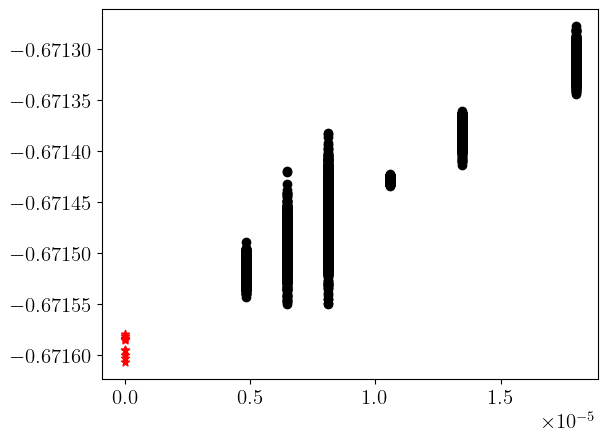

In [10]:
bc = 'periodic'
L_ = 10

plt.figure()

np.random.seed(100)
xs = np.reshape(np.tile(zero_var_energy[bc][L_]['variances'], Nb),(Nb,-1))
residuals = np.array(zero_var_energy[bc][L_]['residuals'])
predicted_ys = np.array(zero_var_energy[bc][L_]['predicted ys'])
gaussian_vars = np.random.normal(loc=0.0,scale=1.0,size=(Nb,len(predicted_ys)))

resampled_ys = predicted_ys + residuals * gaussian_vars

plt.scatter(xs, resampled_ys, color='k')

intercepts = []
for b in range(Nb):
    reg_x = xs[b,:][:,np.newaxis]
    reg_y = resampled_ys[b,:]
    reg = LinearRegression().fit(reg_x, reg_y)     
    intercepts.append(reg.intercept_)
    if b%100==0:
        plt.scatter(0,reg.intercept_,marker='*',color='red')

intercepts = np.array(intercepts)

print("-" * 50)
print("Getting y-int")
print("-" * 50)
print("y-int before:    ", zero_var_energy[bc][L_]['y-int'])
print("y-int BOOTSTRAP: ", np.mean(intercepts))
print("err(y-int) before:    ",zero_var_energy[bc][L_]['y-int err'])
print("err(y-int) BOOTSTRAP: ", np.std(intercepts)/np.sqrt(Nb))


# Save Data

In [11]:
zero_var_energy_final = {}
for bc in ['open', 'periodic']:
    zero_var_energy_final[bc] = {}
    zero_var_energy_final[bc]['energies'] = []
    zero_var_energy_final[bc]['energy errors'] = []
    zero_var_energy_final[bc]['energies bootstrapped'] = []
    zero_var_energy_final[bc]['energy errors bootstrapped'] = []
    for L in Ls:
        if 'y-int' in zero_var_energy[bc][L].keys():
            zero_var_energy_final[bc]['energies'].append(zero_var_energy[bc][L]['y-int'])
            zero_var_energy_final[bc]['energy errors'].append(zero_var_energy[bc][L]['y-int err'])
            zero_var_energy_final[bc]['energies bootstrapped'].append(zero_var_energy[bc][L]['y-int bootstrapped'])
            zero_var_energy_final[bc]['energy errors bootstrapped'].append(zero_var_energy[bc][L]['y-int err bootstrapped'])


In [12]:
final_data_path = './final_data/'
zero_var_energies_save_filename = final_data_path + 'zero_var_energies.pkl'
save_dict(zero_var_energy_final,zero_var_energies_save_filename)